# Phonon wave packet simulation

## 1. Introduction
Phonon wave packet method is a computational technique used to study phonon transport and interactions in materials. It involves constructing a localized 
wave packet that represents a phonon mode and then simulating its evolution over time using the molecular dynamics (MD) method. This approach is particularly useful for investigating phonon-boundary, phonon-defect, and interface issues, which are crucial for understanding phonon thermal transport in materials.
 
In 2002, Schelling et al. [1] proposed this approach for simulating and observing the transport of phonon wave packets, which are formed from linear 
combinations of vibrational eigenstates and can be generated by displacing the atoms according to:

$$u_{il\mu}=A_0\epsilon_{i\mu\lambda}(\mathrm{k}_0)e^{i\mathrm{k}_0(\mathrm{x}-\mathrm{x}_0)}e^{-(\mathrm{x}-\mathrm{x}_0)^2/\eta^2}$$

where $A_0$ represents the amplitude of the wave packet, $\epsilon_{i\mu\lambda}(\mathrm{k}_0)$ is the polarization vector of the $\lambda$ branch under the 
wave vector $k_0$, $x_0$ represents the center position of the wave packet, and $\eta$ is a parameter controlling the spatial extension of the wave packet.

Herein, we perform the phonon wave packet simulation with graphene nanoribbon as an example. We implement the modeling of the initial wave packet by Python, 
where the 
eigenvector information is obtained from Phonopy [2]. Then, **GPUMD** is used to perform the dynamical evolution of the wave packet and visualize the results.

## 2. Prepare the input

First, we got the phonon calculation results, including the phonon dispersion and eigenvectors. In this tutorial, these results were calculated by 
phonopy [2] based on the Tersoff potential, which are in the `phonon` folder. 

Then, we generated a graphene nanoribbon (`code/model_init.xyz`) by `code/model_generate.py` with the aid of ASE tools[3]. The first few lines of the model 
file 
are:
```
200000
Lattice="124.70765814495914 0.0 0.0 0.0 4320.0 0.0 0.0 0.0 3.35" Properties=species:S:1:pos:R:3 pbc="T T F"
C      122.83704327       0.72000000       1.67500000
C      124.08411985       1.44000000       1.67500000
C      124.08411985       2.88000000       1.67500000
C      122.83704327       3.60000000       1.67500000
C      122.83704327       5.04000000       1.67500000
```
Next, we can get the model file with atomic displacement for wave packet simulation after running the `code/WP_Genaration.py` code. Note that, some 
parameters in the code 
 need to be adjusted according to your own case, which have been noted in the code.
 
Herein, we generated the ZA phonon wave packet with the frequency of 3.27 THz, as follows:

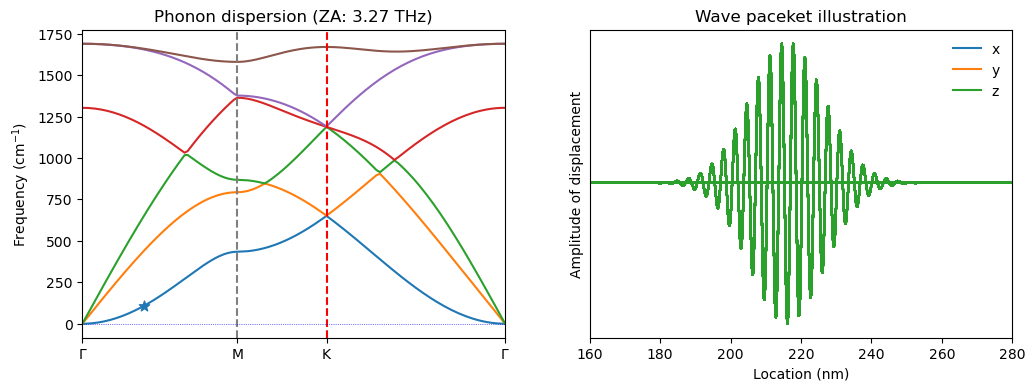

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import ase.io
import math
import cmath
from typing import Dict

class WavePacketHandler:
    """Handles wave packet configuration and phonon band data loading"""

    def __init__(self, config_dict: Dict):
        self.eta = config_dict["eta"]  # controls wave packet width
        self.A0 = config_dict["A0"]  # wave packet amplitude
        self.branch = config_dict["branch"]  # phonon branch
        self.k0 = config_dict["k0"]  # k-point index corresponding to wave number and frequency
        self.direction = config_dict["direction"]  # direction
        self.model_file_path = config_dict["model_file_path"]   # your model
        self.band_file_path = config_dict["band_file_path"]   # your band.yaml from phonopy
        self.dispersion_file_path = config_dict["dispersion_file_path"]   # your band.txt from phonopy
        self.loc_center = config_dict["loc_center"]   # the center location of your wavepacket
        self.u = None
        self.v = None

    # Dictionary mapping for branch and direction values
    BRANCH_MAP = {"ZA": 0, "TA": 1, "LA": 2}
    DIRECTION_MAP = {"x": 0, "y": 1, "z": 2}

    @property
    def branch_index(self) -> int:
        """Get branch index directly as a property"""
        return self.BRANCH_MAP.get(self.branch)

    @property
    def direction_index(self) -> int:
        """Get direction index directly as a property"""
        return self.DIRECTION_MAP.get(self.direction)


    def generate_wave_packet(self):

        model = ase.io.read(self.model_file_path)
        pos = model.positions
        with open(self.band_file_path) as f:
            band_data = yaml.load(f, Loader=yaml.SafeLoader)
        eigenval_data = np.genfromtxt(self.dispersion_file_path)
        eigenval_cm_1 = np.reshape(eigenval_data[:, 1], (-1, 3 * band_data["natom"]), order='F')
        eigenval_THz = eigenval_cm_1 / 33.35641

        index = np.tile([0, 1], len(pos) // 2 + 1)[:len(pos)]

        self.u = np.zeros_like(pos)
        self.v = np.zeros_like(pos)

        d_wavevector = 2.0 * math.pi / (math.sqrt(3) * band_data['nqpoint'] * band_data['lattice'][0][0])

        for i in range(len(pos)):
            idx = int(index[i])
            for j in range(3):
                eigen_vec = complex(
                    band_data['phonon'][self.k0]['band'][self.branch_index]['eigenvector'][idx][j][0],
                    band_data['phonon'][self.k0]['band'][self.branch_index]['eigenvector'][idx][j][1]
                )
                rel_pos = pos[i, self.direction_index] - self.loc_center
                phase = complex(0.0, self.k0 * d_wavevector * rel_pos)
                gaussian = math.exp(-(rel_pos ** 2) / (self.eta ** 2))
                wavepacket = self.A0 * eigen_vec * cmath.exp(phase) * gaussian
                self.u[i, j] = wavepacket.real
    
        model.positions += + self.u
        model.write("model.xyz", format="extxyz")


        # Visualization
        plt.figure(figsize=(12, 4))
        plt.subplots_adjust(wspace=0.2)
        # Plot dispersion relation
        plt.subplot(121)
        for i in range(6):
            plt.plot(eigenval_data[0:band_data['nqpoint'], 0], eigenval_cm_1[:, i])
        # Plot the kpoint you choose
        plt.scatter(eigenval_data[self.k0, 0], band_data['phonon'][self.k0]['band'][self.branch_index]['frequency'], marker='*', s=60)
        # Segments on the wavevector
        gamma0 = eigenval_data[0, 0]
        M = eigenval_data[int(band_data['nqpoint'] / 3), 0]
        K = eigenval_data[int(2 * band_data['nqpoint'] / 3), 0]
        gamma1 = eigenval_data[int(3 * band_data['nqpoint'] / 3) - 1, 0]
        # Labeling and Identification
        plt.xlim(gamma0, gamma1)
        plt.xticks([gamma0, M, K, gamma1], ['$\Gamma$', 'M', 'K', '$\Gamma$'])
        plt.axvline(M, color='gray', ls='--')
        plt.axvline(K, color='red', ls='--')
        plt.axhline(0, color='blue', ls=':', lw=0.5)
        plt.ylabel('Frequency (cm$^{{-1}}$)')
        plt.title(f"Phonon dispersion ({self.branch}: {eigenval_THz[self.k0, self.branch_index]:.2f} THz)")
        # Plot wave packet for check
        plt.subplot(122)
        plt.plot(pos[:, self.direction_index] / 10, self.u[:, 0], label='x')
        plt.plot(pos[:, self.direction_index] / 10, self.u[:, 1], label='y')
        plt.plot(pos[:, self.direction_index] / 10, self.u[:, 2], label='z')
        plt.xlim(160, 280)
        plt.yticks([])
        plt.xlabel('Location (nm)')
        plt.ylabel('Amplitude of displacement')
        plt.title('Wave paceket illustration')

        plt.legend(frameon=False)
        plt.show()

def main():

    config = {
        "eta": 150,
        "A0": 0.01,
        "branch": 'ZA',
        "k0": 20,
        "loc_center": 4.32 * 500,
        "direction": "y",
        "model_file_path": "./code/model_init.xyz",
        "band_file_path": "./phonon/band.yaml",
        "dispersion_file_path": "./phonon/band.txt",
    }

    simulator = WavePacketHandler(config)
    simulator.generate_wave_packet()

if __name__ == '__main__':
    main()

## 3. Perform the MD simulation and visualization

#### MD simulation

After checking by the above output figure, we can get the `model.xyz` for next dynamical evolution of the wave packet by GPUMD. And the `run.in` is as follows: 
```
potential       ./the/path/of/your/potential
velocity        1e-10
ensemble        nve
dump_position   10000
dump_velocity   10000
time_step       1
run             100000
```
The results are in `MD` folder, which took 125 seconds by NVIDIA RTX 4090, and then we can extract the evolution of wave packets through the output trajectory 
file,
 as 
follows:

#### Results visualization 

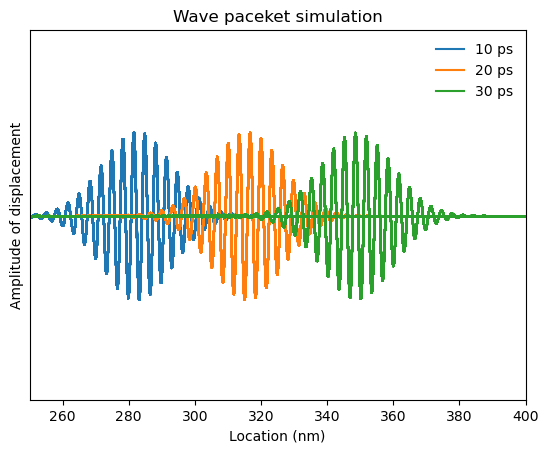

In [7]:
from matplotlib import pyplot as plt
from ase.io import read

data= read(filename='./MD/movie.xyz', index=":")
data_init = read("./MD/model.xyz")

plt.plot(data_init.positions[:, 1] / 10, data[1].positions[:, 2] - data_init.positions[:, 2], label="10 ps")
plt.plot(data_init.positions[:, 1] / 10, data[2].positions[:, 2] - data_init.positions[:, 2], label="20 ps")
plt.plot(data_init.positions[:, 1] / 10, data[3].positions[:, 2] - data_init.positions[:, 2], label="30 ps")

plt.xlim(250, 400)
plt.xlabel('Location (nm)')
plt.ylabel('Amplitude of displacement')
plt.title('Wave paceket simulation')
plt.legend(frameon=False)
plt.yticks([])
plt.show()

### Author's Note
- If you define the wave packet only through atomic displacements, it will split and move in both directions during evolution. That’s sometimes useful—for instance, when you want to compare how it interacts with two different structures at opposite ends. But if you want the wave to move in just one direction, you’ll need to assign initial velocities as well, as demonstrated in the code.
- If you’ve been paying close attention, you might have noticed that we also output velocity data in the `run.in` file. That’s for visualizing wave packet 
energy—super useful when studying transmission and reflection at interfaces. We didn not show the results here, so if you’re curious, go explore it yourself! We didn’t include the velocity files in the repo (they’re quite large), but feel free to run the MD yourself and check it out!

#### If you use it, the following citations are highly recommended: 
- [Wu, X., Huang, X., Yang, L., Zhang, Z., Guo, Y., Volz, S., Han, Q., & Nomura, M. (2023). Suppressed thermal transport in mathematically inspired 2D heterosystems. Carbon, 213, 118264.](https://doi.org/10.1016/j.carbon.2023.118264)
- [Wu, X., Wu, Y., Huang, X., Fan, Z., Volz, S., Han, Q., & Nomura, M. (2024). Isotope interface engineering for thermal transport suppression in cryogenic graphene. Materials Today Physics, 46, 101500.](https://doi.org/10.1016/j.mtphys.2024.101500)


##  References
[[1]](https://doi.org/10.1063/1.1465106) Schelling, P. K., Phillpot, S. R., & Keblinski, P. (2002). Phonon wave-packet dynamics at semiconductor interfaces 
by molecular-dynamics simulation. Applied Physics Letters, 80(14), 2484-2486.

[[2]](https://doi.org/10.7566/JPSJ.92.012001) Togo, A. (2023). First-principles phonon calculations with phonopy and phono3py. Journal of the Physical Society of Japan, 92(1), 012001.

[[3]](https://wiki.fysik.dtu.dk/ase/index.html) The Atomic Simulation Environment (ASE) is a set of tools and Python modules for setting up, manipulating, running, visualizing and analyzing atomistic simulations. The code is freely available under the GNU LGPL license.


